# Regression using gaussian processes

In [2]:
import sys

sys.path.insert(0, "..")

# Import the gaussian process claas
from gaussian_processes import One_d_gaussian_process
from kernels import rbf_kernel

# Load in the diabetes dataset
from sklearn import datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Diabetes dataset

This is an inbuilt dataset to Scikit learn with the following qualities as dependent variables:

* age: age in years
* sex
* bmi: body mass index
* bp: average blood pressure
* s1: tc, total serum cholesterol
* s2: ldl, low-density lipoproteins
* s3: hdl, high-density lipoproteins
* s4: tch, total cholesterol / HDL
* s5: ltg, possibly log of serum triglycerides level
* s6: glu, blood sugar level

The indepdentent variable is a quantitative measure of disease progression one year after baseline.

### Load in the dataset

In [3]:
# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_df = datasets.load_diabetes(as_frame=True)

### Inspect the features

In [6]:
print(
    f"The Diabetes data has {diabetes_X.shape[1]} features \nthe feature names are {diabetes_df.feature_names}"
)

The Diabetes data has 10 features 
the feature names are ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


#### What do all the variables look like plotted against the independent variable?

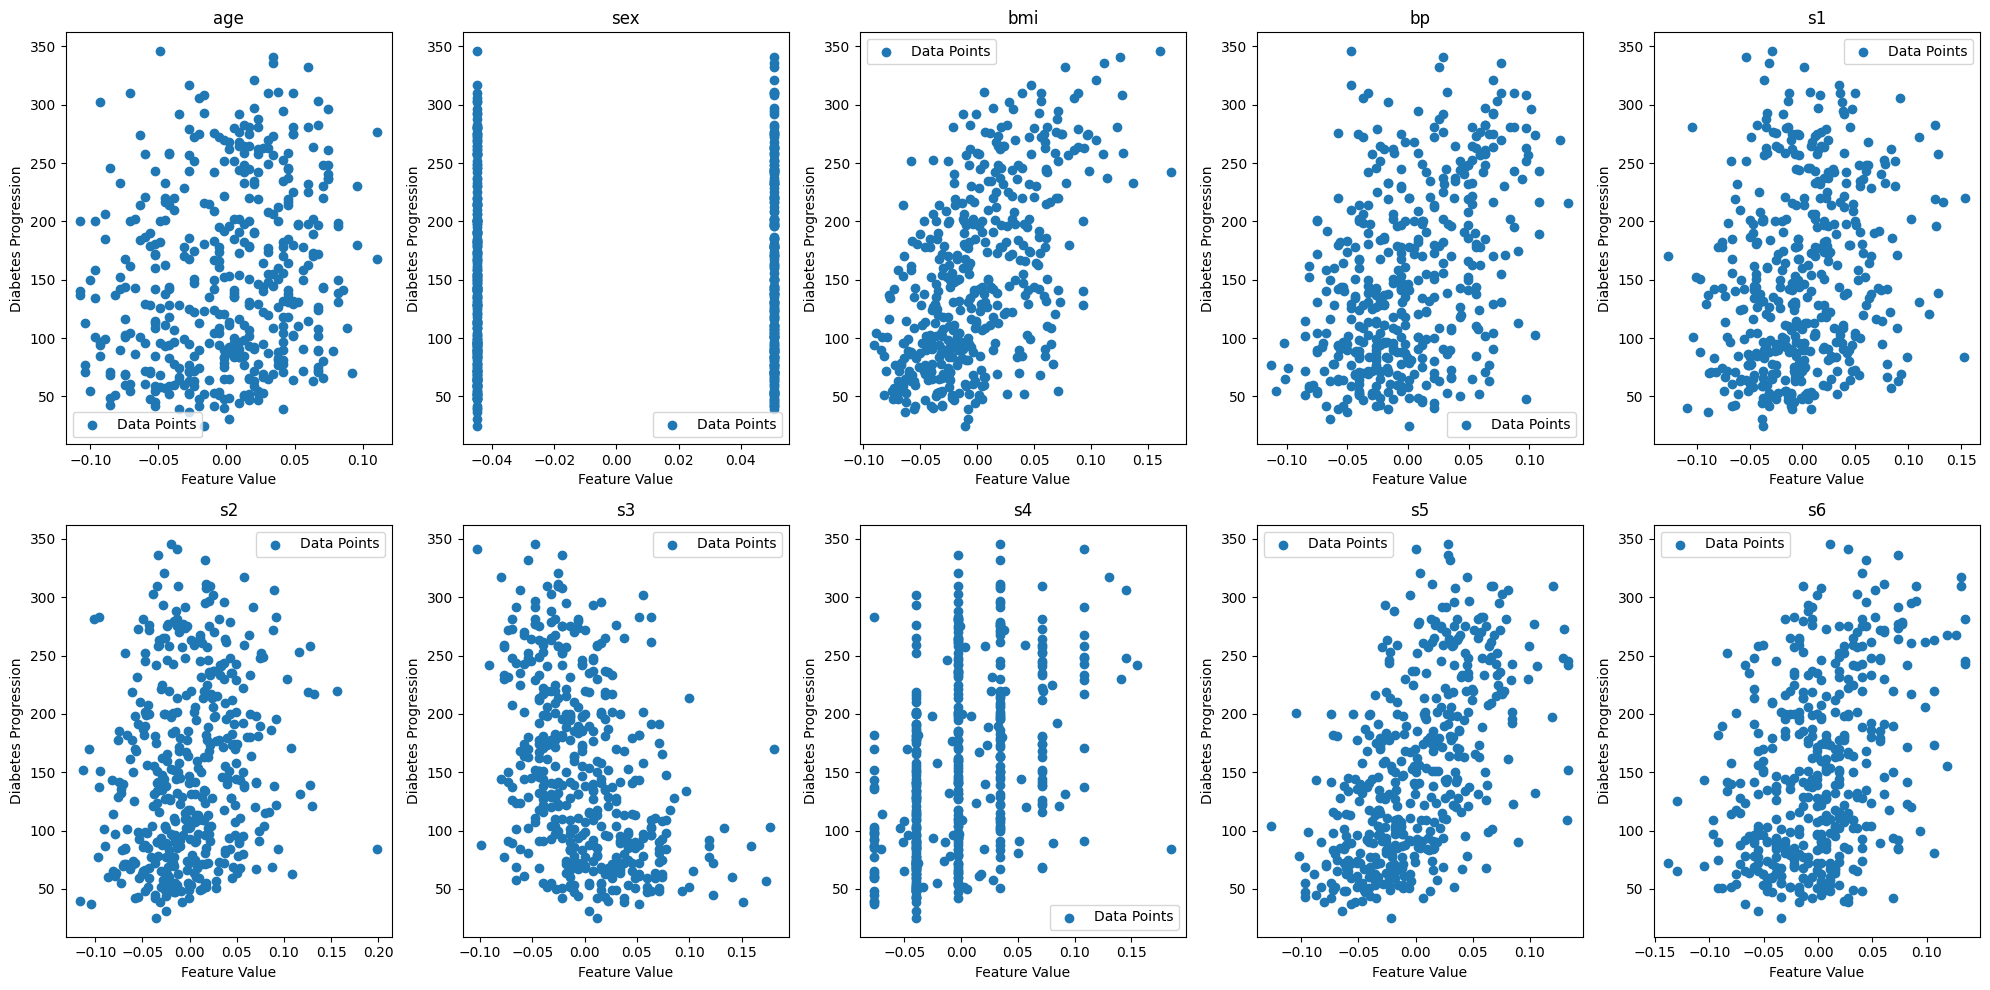

In [7]:
# Plot all features against the diabetes target variable in a subplot of 2x5
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i // 5, i % 5].scatter(diabetes_X[:, i], diabetes_y, label="Data Points")
    axs[i // 5, i % 5].set_title(diabetes_df.feature_names[i])
    axs[i // 5, i % 5].set_xlabel("Feature Value")
    axs[i // 5, i % 5].set_ylabel("Diabetes Progression")
    axs[i // 5, i % 5].legend()

# Make the plot tight, this means that the subplots will not overlap
plt.tight_layout()

plt.show()

Some

#### Are there correlates across the dependent variables?

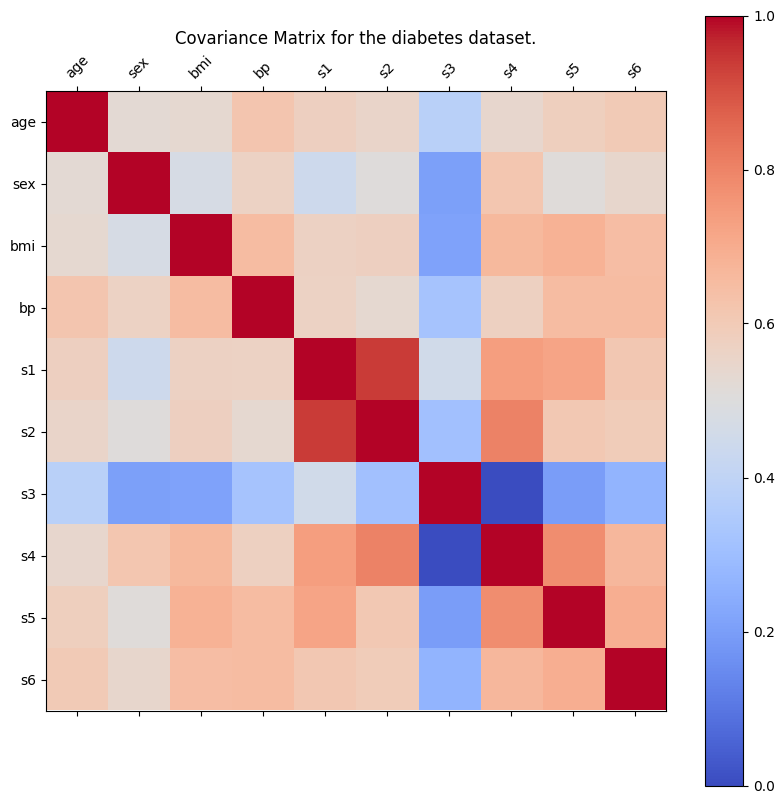

In [8]:
# Is there covariance between the dependent variables in this dataset?
# The covariance matrix is a matrix that shows the covariance between each pair of features
covariance = np.cov(diabetes_X.T)

# Minmax normalise the covariance (between 0 and 1)
covariance = (covariance - np.min(covariance)) / (
    np.max(covariance) - np.min(covariance)
)

# Create a heatmap of the covariances between the independent variables
fig, ax = plt.subplots(figsize=(10, 10))
# Define the color map
cax = ax.matshow(covariance, cmap="coolwarm")
plt.colorbar(cax)

# Set the x ticks and y ticks
ax.set_xticks(np.arange(len(diabetes_df.feature_names)))
ax.set_yticks(np.arange(len(diabetes_df.feature_names)))
ax.set_xticklabels(diabetes_df.feature_names, rotation=45)
ax.set_yticklabels(diabetes_df.feature_names)

# Title the plot
plt.title("Covariance Matrix for the diabetes dataset.")
plt.show()

We see that there is some covariance here, so the dependent variables are not independent of one another. Therefore we cannot (well... should not, more on this later) create a gaussian process for each dependent variable.

#### Importance scoring of the dependent variables

In [155]:
# First we need to use the PCA (Principal Component Analysis) method to find the eigenvalues and eigenvectors of the covariance matrix
from sklearn.decomposition import PCA
# Create the PCA object
pca = PCA(n_components=5)
# Fit the PCA object to the data
pca.fit(diabetes_X)
# Transform the data
diabetes_X_pca = pca.transform(diabetes_X)
# Get the eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
# Print the eigenvalues and eigenvectors
print(f"Eigenvalues: {eigenvalues}")


Eigenvalues: [0.00912519 0.00338394 0.00273462 0.00216661 0.00150155]


$$ \sum_{i=1}^n (\bold{x}_i^T\bold{u})^2 =\ \sum_{i=1}^n (\bold{x}_i^T\bold{u})(\bold{x}_i^T\bold{u}) \text{ (The dot product is symmetric)}=\ \sum_{i=1}^n\bold{u}^T\bold{x}_i\bold{x}_i^T\bold{u} =\ \bold{u}^T(\sum_{i=1}^n\bold{x}_i\bold{x}_i)\bold{u} =\ \bold{u}^TC\bold{u} $$

# Principal Component Analysis (PCA)

PCA is a way for us to reduce the dimensionality of our data so that the most important information is conserved, in general if we have $n$ features we can reduce the features down using PCA to any number less than or equal to $n$. But how do we do this?

Suppose we have a set of $m$ dimensional datapoints $\bold{x}_i$ and we want to find a representation of these features that is $d$ dimensional where $d \leq m$, we want these $d$ dimensional features to retain as much information as is possible. So what does it even mean to reduce the dimensionality? It corresponds to projection onto a line or plane, a projection of a vector $\bold{x}$ onto a unit vector $\bold{u}$ is defined as $\text{proj}(\bold{x})_{\bold{u}} = (\bold{x}\bold{u}^T)\bold{u}$ where $\bold{x}\bold{u}^T$ can be viewed as the similarity between $\bold{x}$ and $\bold{u}$, thus we want to make that quantity as large as possible (which is possible when $\bold{x}$ is paralell to $\bold{u}$). Thus we want to define a line with direction $\bold{u}$ such that each feature vector is as similar as possible to it, and project the feature vectors onto it, we can frame this as an optimisation problem

$$
\max \sum_{i=1}^n (\bold{x}_i\bold{u}^T)^2 \\
\text{subject to } \bold{u}\bold{u}^T = 1 \text{ (unit vector))}
$$

We can rewrite our objective function as follows:

$$
\sum_{i=1}^n (\bold{x}_i^T\bold{u})^2 =\\
\sum_{i=1}^n (\bold{x}_i^T\bold{u})(\bold{x}_i^T\bold{u}) \text{ (The dot product is symmetric)}=\\ 
\sum_{i=1}^n\bold{u}^T\bold{x}_i\bold{x}_i^T\bold{u} =\\ 
\bold{u}^T(\sum_{i=1}^n\bold{x}_i\bold{x}_i)\bold{u} =\\
\bold{u}^TC\bold{u}
$$

Where $C$ is known as the `covariance matrix` and is defined as $C = \frac{1}{n}\sum_{i=1}^n \bold{x}_i\bold{x}_i^T$.

We know that $C$ is a positive definite matrix, and is thus convex, since all of it's elemets must be greater than zero, this means that we can find a global minimum using the `lagrange multiplier` technique, as follows

We introduce a `lagrange paramater` $\lambda$ that defines our lagrange equation:

$$
L(\bold{u}, C, \lambda) =\bold{u}^TC\bold{u}-\lambda(\bold{u}\bold{u}^T - 1) \\
\nabla{L} = C\bold{u} - \lambda\bold{u} \implies \\
C\bold{u} = \lambda\bold{u} \text{ when } \nabla{L} = 0
$$

Which is simply the equation for the eigenvalues of $C$. Note that $C_{ij} = \frac{1}{n}\text{Cov}(\bold{x}_i, \bold{x}_j)$, calculating covariances makes sense as we want to find a line that contains the linear combinations of variables that lead to the most variance in the data and thus carry the most information aobut the data!

Note that $C$ is also symmetric, since the covariance is symmetric we know that the eigenvalues of $C$, $\bold{u}_\lambda$ are orthogonal, so $\bold{u}_\lambda\bold{u}_\lambda^T = 0$ thus it is true that:

$$
C\bold{u} = \lambda\bold{u} \implies \bold{u}^TC\bold{u} = \lambda
$$

This means that the eigenvalue of the covariance is the exact same as the measure of similairty to the eigenvector $\bold{u}$ that we saw before! So we have an interperetation of ranking of how important our principal components are!

So, given a principle direction $\bold{u}$ (which is an eigenvector of $C$) we have an order of imporance $\lambda$ (the eigenvalue corresponding to the principle direction) that allows us to score how much the principle components impact the variance.

So given a principle direction and a datapoint, we can project the datapoint onto the line of the principle direction to get the components of our vectors :), and we can choose up to $n$ eigenvectors to do this with!

So given a principle component $\bold{u}$ (unit vector) and a datapoint $\bold{x}$ we project $\bold{x}$ onto it by finding the inner product between the two, thus the principle component corresponding to $\bold{x}$ has a value of $\bold{x} . \bold{u}$.

In the case when we have a matrix of data $X$ where rows are datapoints, we calcualte it's covariance matrix $C$ and find it's eigenvectors $\bold{u}_{\lambda_i}$ then we can calculate all of the principle components by multiplying our data and our eigenvector which gives $\text{PC}_{\lambda_i} = X \bold{u}_{\lambda_i}$, so if we have a matrix $U = (\bold{u}_{\lambda_0}, \dots, \bold{u}_{\lambda_n})$ we can define ALL of our principal components as $\text{PC} = XU$.

## Apply the gaussian process

In [146]:
# Define the training inputs
variable_index = 2
trianing_samples = 50

# Randomly sample some indices from the diabetes dataset
indices = np.random.choice(
    diabetes_X.shape[0], size=trianing_samples, replace=False
)
# Get the training inputs
training_inputs = diabetes_X[indices, variable_index]
# Get the training outputs
training_outputs = diabetes_y[indices]

# Then the testing inputs are just the Diabetes X data.
testing_inputs = diabetes_X[:, variable_index]

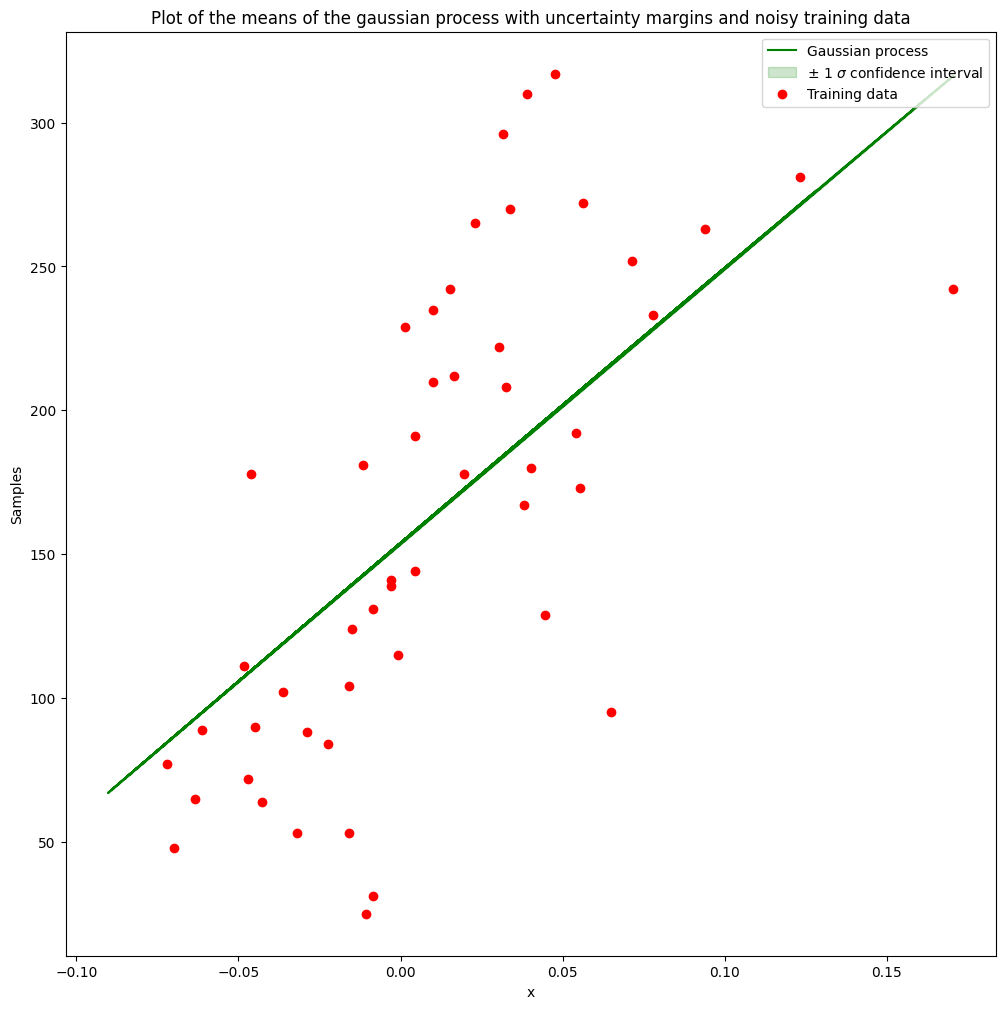

In [147]:
# We will create a gaussian process for the first dependent variable, and then we will use that to predict the independent variable.
# Create a gaussian process for the first dependent variable

gaussian_process = One_d_gaussian_process(
    training_inputs=training_inputs,
    training_outputs=training_outputs,
    testing_range=testing_inputs,
    kernel=rbf_kernel,
    noise=0.05,
)

gaussian_process.visualise()

### Assess the accuracy of the process (looking through the lens of this univariate)

[]

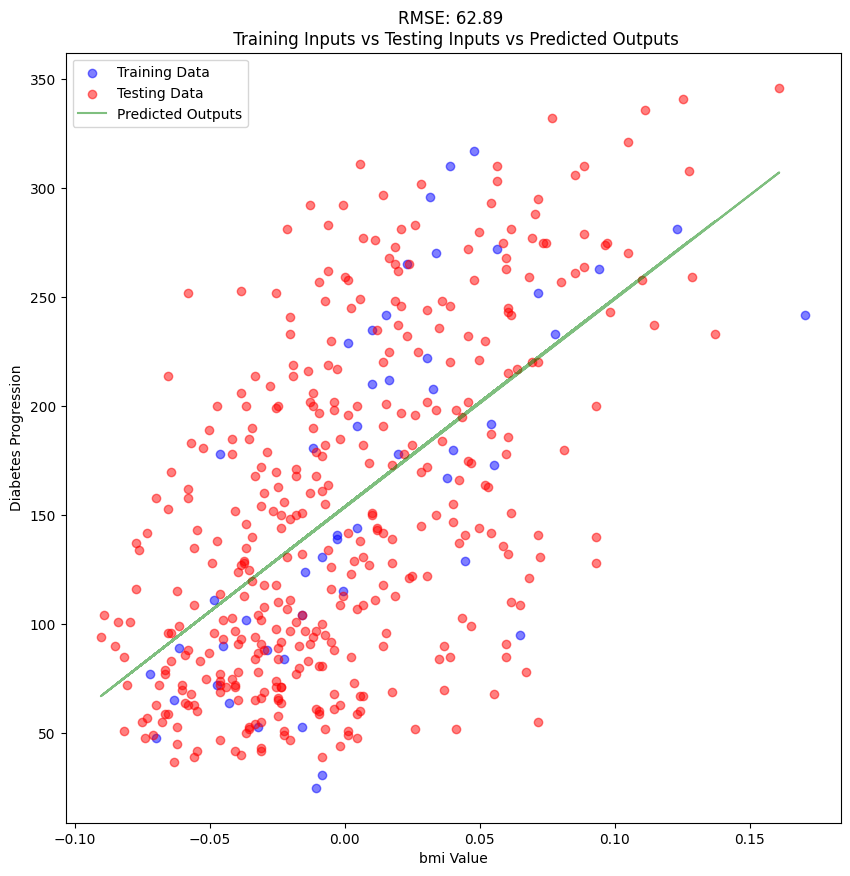

In [148]:
# The testing outputs are the indicies that were not used in training
testing_indices = np.delete(
    np.arange(diabetes_X.shape[0]), indices
)  # The indices of the testing inputs
testing_inputs = diabetes_X[testing_indices, variable_index]  # The testing inputs
testing_outputs = diabetes_y[testing_indices]  # The testing outputs

# Now we can use the gaussian process to predict the outputs for the testing inputs
gp_predicted_outputs = gaussian_process.conditioned_mean[testing_indices]

# Calculate RMSE value
rmse = np.sqrt(np.mean((gp_predicted_outputs - testing_outputs) ** 2))

# Plot these against eachother
fig, ax = plt.subplots(figsize=(10, 10))
# Plot training inputs and outputs
ax.scatter(
    training_inputs, training_outputs, label="Training Data", color="blue", alpha=0.5
)

# Plot the testing inputs and outputs
ax.scatter(
    testing_inputs, testing_outputs, label="Testing Data", color="red", alpha=0.5
)
# Plot the predicted outputs
ax.plot(
    testing_inputs,
    gp_predicted_outputs,
    label="Predicted Outputs",
    color="green",
    alpha=0.5,
)

# Set the x label
ax.set_xlabel(f"{diabetes_df.feature_names[variable_index]} Value")

# Set the y label
ax.set_ylabel("Diabetes Progression")

# Title the plot
ax.set_title(f"RMSE: {rmse:.2f} \n Training Inputs vs Testing Inputs vs Predicted Outputs"
)
plt.legend()
plt.plot()

### Compare this performance to a linear regressor trained with the same data

[]

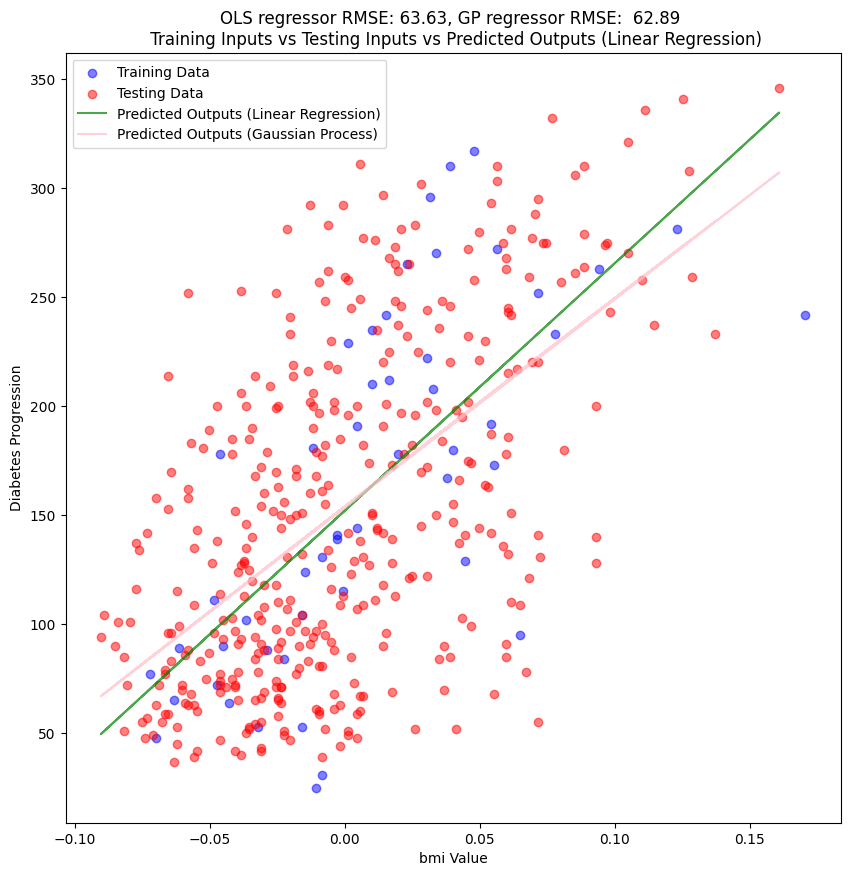

In [153]:
# Linear regression fitted with the same data
from sklearn.linear_model import LinearRegression

# Create a linear regression model
linear_regression = LinearRegression()
# Fit the model to the training data
linear_regression.fit(training_inputs.reshape(-1, 1), training_outputs)
# Predict the outputs for the testing data
predicted_outputs_lr = linear_regression.predict(
    testing_inputs.reshape(-1, 1)
)  # The predicted outputs
# Calculate RMSE value
rmse_lr = np.sqrt(np.mean((predicted_outputs_lr - testing_outputs) ** 2))
# Plot these against eachother
fig, ax = plt.subplots(figsize=(10, 10))
# Plot training inputs and outputs
ax.scatter(
    training_inputs, training_outputs, label="Training Data", color="blue", alpha=0.5
)
# Plot the testing inputs and outputs
ax.scatter(
    testing_inputs, testing_outputs, label="Testing Data", color="red", alpha=0.5
)
# Plot the predicted outputs
ax.plot(
    testing_inputs,
    predicted_outputs_lr,
    label="Predicted Outputs (Linear Regression)",
    color="green",
    alpha=0.7,
)
# Plot the gaussian predicted outputs
ax.plot(
    testing_inputs,
    gp_predicted_outputs,
    label="Predicted Outputs (Gaussian Process)",
    color="pink",
    alpha=0.7,
)
# Set the x label
ax.set_xlabel(f"{diabetes_df.feature_names[variable_index]} Value")
# Set the y label
ax.set_ylabel("Diabetes Progression")
# Title the plot
ax.set_title(f"OLS regressor RMSE: {rmse_lr:.2f}, GP regressor RMSE: {rmse: .2f} \n Training Inputs vs Testing Inputs vs Predicted Outputs (Linear Regression)"
)
plt.legend()
plt.plot()

### Compare performance as a function of sample size using RMSE

In [98]:
def randomly_sample_indices(data: np.array, size: int) -> np.array:
    """
    Randomly sample the data and return the indices of the sampled data.
    This is used to sample the training data from the dataset.
    """
    # Randomly sample some indices from the diabetes dataset
    indices = np.random.choice(data.shape[0], size=size, replace=False)
    return indices

def get_training_data(data: np.array, indices: np.array) -> tuple:
    """
    Get the training data from the dataset.
    This is used to get the training inputs and outputs from the dataset.
    """
    # Get the training inputs
    training_inputs = data[indices, variable_index]
    # Get the training outputs
    training_outputs = diabetes_y[indices]
    return training_inputs, training_outputs

def get_testing_data(data: np.array, indices: np.array) -> tuple:
    """
    Get the testing data from the dataset.
    This is used to get the testing inputs and outputs from the dataset.
    """
    # The testing indices are the indicies that were not used in training
    testing_indices = np.delete(np.arange(data.shape[0]), indices)
    # The testing inputs are the diabetes X data
    testing_inputs = data[testing_indices, variable_index]
    # The testing outputs are the diabetes y data
    testing_outputs = diabetes_y[testing_indices]
    return testing_inputs, testing_outputs, testing_indices

def get_rmse(predicted_outputs: np.array, testing_outputs: np.array) -> float:
    """
    Calculate the RMSE value for the predicted outputs and the testing outputs.
    This is used to calculate the RMSE value for the predicted outputs.
    """
    rmse = np.sqrt(np.mean((predicted_outputs - testing_outputs) ** 2))
    return rmse

def get_gp_preds(training_inputs: np.array, training_outputs: np.array, testing_inputs: np.array, testing_indices: np.array) -> np.array:
    """
    Get the predicted outputs for the testing data using the Gaussian Process.
    This is used to get the predicted outputs for the testing data.
    """
    # Create a gaussian process for the first dependent variable
    gaussian_process = One_d_gaussian_process(
        training_inputs=training_inputs,
        training_outputs=training_outputs,
        testing_range=testing_inputs,
        kernel=rbf_kernel,
        noise=0.05,
    )
    # Use the gaussian process to predict the outputs for the testing inputs
    predicted_outputs = gaussian_process.conditioned_mean[testing_indices]
    return predicted_outputs


def get_lr_preds(training_inputs: np.array, training_outputs: np.array) -> np.array:
    """
    Get the predicted outputs for the testing data using Linear Regression.
    This is used to get the predicted outputs for the testing data.
    """
    # Create a linear regression model
    linear_regression = LinearRegression()
    # Fit the model to the training data
    linear_regression.fit(training_inputs.reshape(-1, 1), training_outputs)
    # Predict the outputs for the testing data
    predicted_outputs_lr = linear_regression.predict(
        testing_inputs.reshape(-1, 1)
    )  # The predicted outputs
    return predicted_outputs_lr

In [81]:
from tqdm import tqdm

In [117]:
gp_rmses = []
lr_rmses = []

increment_size = 2
range_min = 1
range_max = 400
for samples in tqdm(range(range_min, range_max + 1, increment_size)):
    training_indices = randomly_sample_indices(diabetes_X, samples)
    training_inputs, training_outputs = get_training_data(diabetes_X, training_indices)
    testing_inputs, testing_outputs, testing_indices = get_testing_data(
        diabetes_X, training_indices
    )
    # Create a gaussian process for the first dependent variable
    predicted_outputs = get_gp_preds(
        training_inputs,
        training_outputs,
        diabetes_X[:, variable_index],
        testing_indices,
    )
    # Calculate RMSE value
    gp_rmse = get_rmse(predicted_outputs, testing_outputs)

    # Create a linear regression model
    predicted_outputs_lr = get_lr_preds(training_inputs, training_outputs)
    # Calculate RMSE value
    lr_rmse = get_rmse(predicted_outputs_lr, testing_outputs)
    # Append the RMSE values to the lists
    gp_rmses.append(gp_rmse)
    lr_rmses.append(lr_rmse)

100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


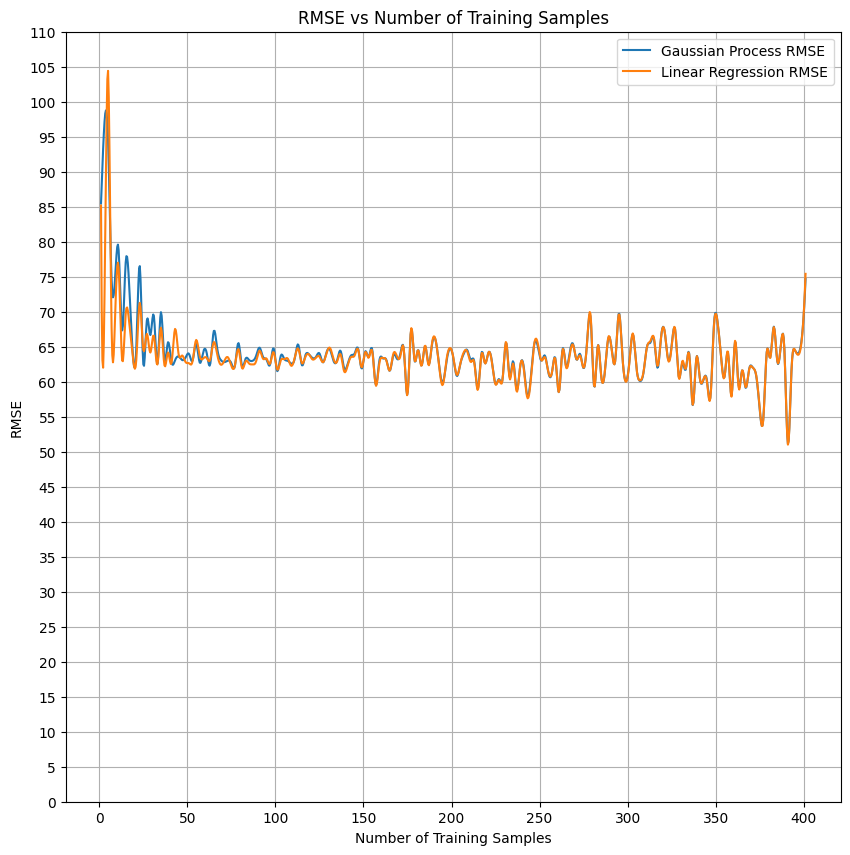

In [125]:
# Smooth out these plots using the magic of splines
from scipy.interpolate import make_interp_spline

fig, ax = plt.subplots(figsize=(10, 10))

smooth_gps = make_interp_spline(
    np.arange(range_min, range_max + 1, increment_size), gp_rmses
)
smooth_lr = make_interp_spline(
    np.arange(range_min, range_max + 1, increment_size), lr_rmses
)

plotting_range = np.arange(range_min, range_max + 1, increment_size)
smoothed_plotting_range = np.linspace(
    range_min, range_max + 1, 1000
)  # 1000 points between the min and max
ax.plot(
    smoothed_plotting_range,
    smooth_gps(smoothed_plotting_range),
    label="Gaussian Process RMSE",
)
ax.plot(
    smoothed_plotting_range,
    smooth_lr(smoothed_plotting_range),
    label="Linear Regression RMSE",
)
plt.xlabel("Number of Training Samples")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0,100)
plt.grid()
plt.title("RMSE vs Number of Training Samples")
plt.yticks(np.arange(0,111,5))
plt.show()

We see that the gaussian regressor performs equally well against the linear regressor in this dimension, performing better than th elinear regressor with lower volumes of data.

## Investigating multi-dimensional regression despite co-variance.

In [136]:
def randomly_sample_indices(data: np.array, size: int) -> np.array:
    """
    Randomly sample the data and return the indices of the sampled data.
    This is used to sample the training data from the dataset.
    """
    # Randomly sample some indices from the diabetes dataset
    indices = np.random.choice(data.shape[0], size=size, replace=False)
    return indices


def get_training_data(data: np.array, indices: np.array) -> tuple:
    """
    Get the training data from the dataset.
    This is used to get the training inputs and outputs from the dataset.
    """
    # Get the training inputs
    training_inputs = data[indices, :]
    # Get the training outputs
    training_outputs = diabetes_y[indices]
    return training_inputs, training_outputs


def get_testing_data(data: np.array, indices: np.array) -> tuple:
    """
    Get the testing data from the dataset.
    This is used to get the testing inputs and outputs from the dataset.
    """
    # The testing indices are the indicies that were not used in training
    testing_indices = np.delete(np.arange(data.shape[0]), indices)
    # The testing inputs are the diabetes X data
    testing_inputs = data[testing_indices, :]
    # The testing outputs are the diabetes y data
    testing_outputs = diabetes_y[testing_indices]
    return testing_inputs, testing_outputs, testing_indices


def get_rmse(predicted_outputs: np.array, testing_outputs: np.array) -> float:
    """
    Calculate the RMSE value for the predicted outputs and the testing outputs.
    This is used to calculate the RMSE value for the predicted outputs.
    """
    rmse = np.sqrt(np.mean((predicted_outputs - testing_outputs) ** 2))
    return rmse


def get_gp_preds_multi_d(
    training_inputs: np.array,
    training_outputs: np.array,
    testing_inputs: np.array,
    testing_indices: np.array,
) -> np.array:
    """
    Get the predicted outputs for the testing data using the Gaussian Process.
    This is used to get the predicted outputs for the testing data.
    """
    # For each dimension of the data, we will create a gaussian process
    num_features = training_inputs.shape[1]

    gp_pred_list = []
    for i in range(num_features):
        # Get gp preds
        gp_preds = get_gp_preds(
            training_inputs[:, i],
            training_outputs,
            testing_inputs[:, i],
            testing_indices,
        )
        gp_pred_list.append(gp_preds)

    # Aggregate the outputs as a mean
    predicted_outputs = np.mean(gp_pred_list, axis=0)

    return predicted_outputs


def get_lr_preds(training_inputs: np.array, training_outputs: np.array) -> np.array:
    """
    Get the predicted outputs for the testing data using Linear Regression.
    This is used to get the predicted outputs for the testing data.
    """
    # Create a linear regression model
    linear_regression = LinearRegression()
    # Fit the model to the training data
    linear_regression.fit(training_inputs, training_outputs)
    # Predict the outputs for the testing data
    predicted_outputs_lr = linear_regression.predict(
        testing_inputs
    )  # The predicted outputs
    return predicted_outputs_lr

In [141]:
gp_rmses = []
lr_rmses = []

increment_size = 5
range_min = 1
range_max = 400

for samples in tqdm(range(range_min, range_max + 1, increment_size)):
    training_indices = randomly_sample_indices(diabetes_X, samples)
    training_inputs, training_outputs = get_training_data(diabetes_X, training_indices)
    testing_inputs, testing_outputs, testing_indices = get_testing_data(
        diabetes_X, training_indices
    )
    # Create a gaussian process for the first dependent variable
    predicted_outputs = get_gp_preds_multi_d(
        training_inputs,
        training_outputs,
        diabetes_X,
        testing_indices,
    )
    # Calculate RMSE value
    gp_rmse = get_rmse(predicted_outputs, testing_outputs)

    # Create a linear regression model
    predicted_outputs_lr = get_lr_preds(training_inputs, training_outputs)
    # Calculate RMSE value
    lr_rmse = get_rmse(predicted_outputs_lr, testing_outputs)
    # Append the RMSE values to the lists
    gp_rmses.append(gp_rmse)
    lr_rmses.append(lr_rmse)

100%|██████████| 80/80 [04:34<00:00,  3.43s/it]


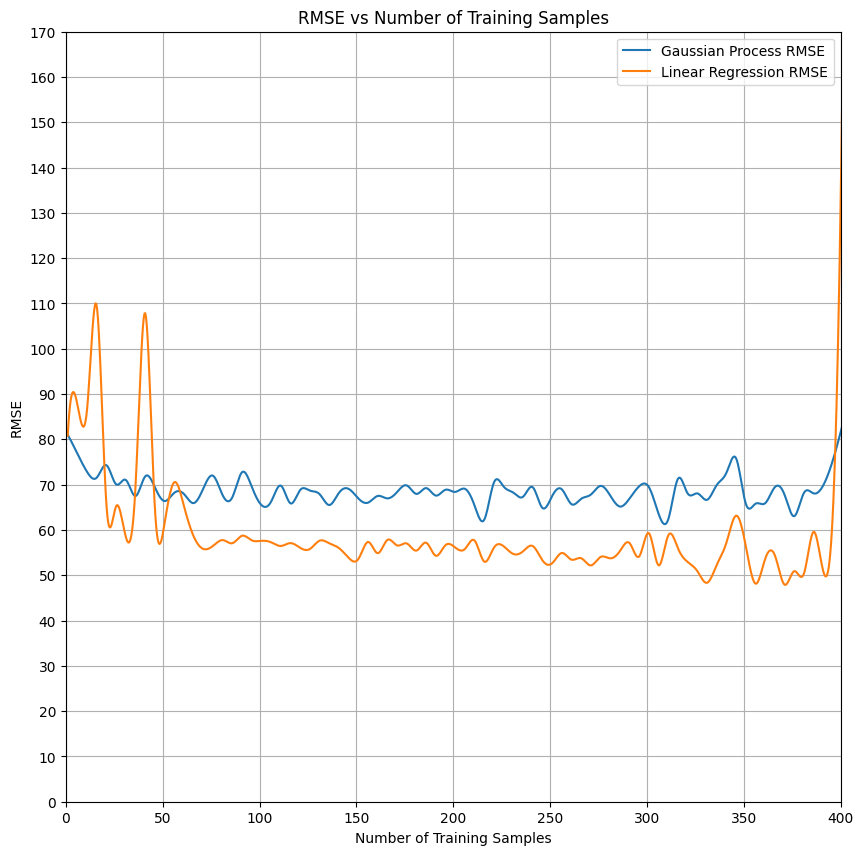

In [144]:
# Smooth out these plots using the magic of splines
from scipy.interpolate import make_interp_spline

fig, ax = plt.subplots(figsize=(10, 10))

smooth_gps = make_interp_spline(
    np.arange(range_min, range_max + 1, increment_size), gp_rmses
)
smooth_lr = make_interp_spline(
    np.arange(range_min, range_max + 1, increment_size), lr_rmses
)

plotting_range = np.arange(range_min, range_max + 1, increment_size)
smoothed_plotting_range = np.linspace(
    range_min, range_max + 1, 1000
)  # 1000 points between the min and max
ax.plot(
    smoothed_plotting_range,
    smooth_gps(smoothed_plotting_range),
    label="Gaussian Process RMSE",
)
ax.plot(
    smoothed_plotting_range,
    smooth_lr(smoothed_plotting_range),
    label="Linear Regression RMSE",
)
plt.xlabel("Number of Training Samples")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0, 170)
plt.xlim(0, 400)
plt.grid()
plt.title("RMSE vs Number of Training Samples")
plt.yticks(np.arange(0, 171, 10))
plt.show()

Here the linear regression clearly begins to outperform the gaussian process. This is due to the linear regression model being able to account for co-variance in the input data, whereas the gaussian process can only view one dimension at a time and aggregate.